In [1]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [85]:
with open('/content/drive/MyDrive/ir_project/binaries/stock_data_with_indicators', 'rb') as fileobj:
  gstock_data= pickle.load(fileobj)

In [86]:
gstock_data .head()

,Unnamed: 0,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),Sochastic oscillator index,William index,Relative Strength Index
0,0,2010-01-04,5200.90,5238.45,5167.10,5232.20,148652424,6531.61,0.0,0.0,0.000000
1,1,2010-01-05,5277.15,5288.35,5242.40,5277.90,240844424,7969.62,0.0,0.0,100.000000
2,2,2010-01-06,5278.15,5310.85,5260.05,5281.80,216147837,7892.60,0.0,0.0,100.000000
3,3,2010-01-07,5281.80,5302.55,5244.75,5263.10,181246734,6890.99,0.0,0.0,92.725757
4,4,2010-01-08,5264.25,5276.75,5234.70,5244.75,201910800,7777.04,0.0,0.0,85.597397


In [87]:
gstock_data = gstock_data [['Date','Open','Close']] 
gstock_data ['Date'] = gstock_data ['Date'].dt.date
gstock_data .set_index('Date',drop=True,inplace=True) 
gstock_data .head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,Close
Date,,
2010-01-04,5200.90,5232.20
2010-01-05,5277.15,5277.90
2010-01-06,5278.15,5281.80
2010-01-07,5281.80,5263.10
2010-01-08,5264.25,5244.75


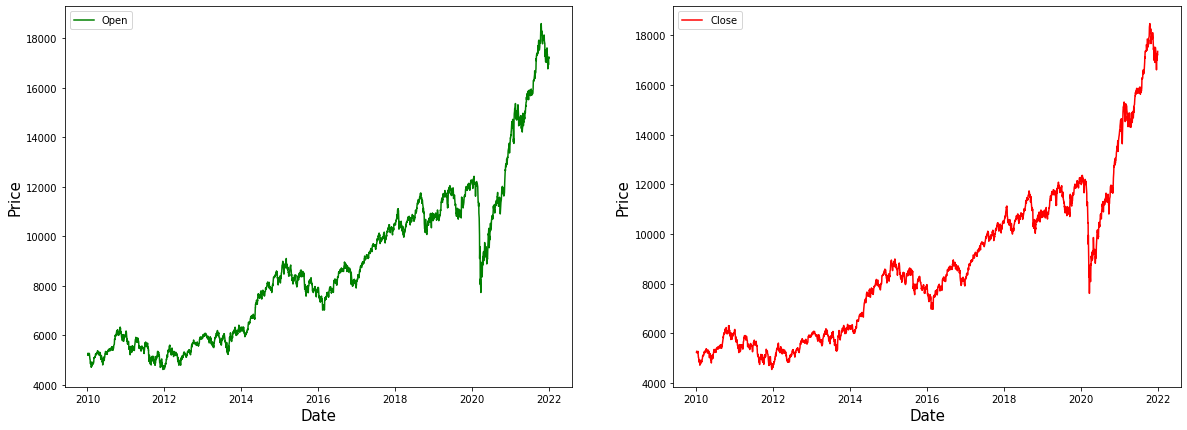

In [88]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(gstock_data ['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()
ax[1].plot(gstock_data ['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()
fg.show()

In [89]:
from sklearn.preprocessing import MinMaxScaler
Ms = MinMaxScaler()
gstock_data [gstock_data .columns] = Ms.fit_transform(gstock_data )

In [90]:
training_size = round(len(gstock_data ) * 0.80)

In [91]:
train_data = gstock_data [:training_size]
test_data  = gstock_data [training_size:]

In [92]:
def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)): 
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [93]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [105]:
train_seq.shape

(2332, 50, 2)

In [95]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [112]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50, 50)            10600     
                                                                 
 dropout_3 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 2)                 102       
                                                                 
Total params: 30,902
Trainable params: 30,902
Non-trainable params: 0
_________________________________________________________________


In [113]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
73/73 [==============================] - 8s 62ms/step - loss: 0.0037 - mean_absolute_error: 0.0332 - val_loss: 0.0041 - val_mean_absolute_error: 0.0521
Epoch 2/80
73/73 [==============================] - 3s 44ms/step - loss: 2.2125e-04 - mean_absolute_error: 0.0114 - val_loss: 0.0026 - val_mean_absolute_error: 0.0375
Epoch 3/80
73/73 [==============================] - 3s 44ms/step - loss: 1.9811e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0036 - val_mean_absolute_error: 0.0484
Epoch 4/80
73/73 [==============================] - 3s 45ms/step - loss: 1.9460e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0028 - val_mean_absolute_error: 0.0410
Epoch 5/80
73/73 [==============================] - 3s 44ms/step - loss: 1.8691e-04 - mean_absolute_error: 0.0105 - val_loss: 0.0023 - val_mean_absolute_error: 0.0370
Epoch 6/80
73/73 [==============================] - 3s 44ms/step - loss: 1.8635e-04 - mean_absolute_error: 0.0105 - val_loss: 0.0019 - val_mean_absolute_error: 0.0334
Ep

In [114]:
test_predicted = model.predict(test_seq)

In [115]:
test_inverse_predicted = Ms.inverse_transform(test_predicted)

In [116]:
# Merging actual and predicted data for better visualization
gs_slic_data = pd.concat([gstock_data .iloc[-546:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=gstock_data .iloc[-546:].index)], axis=1)

In [117]:
gs_slic_data[['open','close']] = Ms.inverse_transform(gs_slic_data[['Open','Close']])

In [118]:
gs_slic_data.head()

,Open,Close,open_predicted,close_predicted,open,close
Date,,,,,,
2019-10-25,0.502389,0.505259,11532.540039,11451.904297,11646.15,11583.90
2019-10-27,0.503541,0.508363,11534.441406,11453.067383,11662.25,11627.15
2019-10-29,0.502232,0.519825,11569.873047,11486.144531,11643.95,11786.85
2019-10-30,0.519397,0.523934,11674.364258,11585.606445,11883.90,11844.10
2019-10-31,0.519865,0.526328,11786.032227,11694.626953,11890.45,11877.45


In [119]:
e=0
for ind in gs_slic_data.index:
  e+=(gs_slic_data['open'][ind]-gs_slic_data['open_predicted'][ind])*(gs_slic_data['open'][ind]-gs_slic_data['open_predicted'][ind])
e=e/len(gs_slic_data)
print(np.sqrt(e))

339.9949734354341


In [29]:
e=0
for ind in gs_slic_data.index:
  e+=(gs_slic_data['close'][ind]-gs_slic_data['close_predicted'][ind])*(gs_slic_data['close'][ind]-gs_slic_data['close_predicted'][ind])
e=e/len(gs_slic_data)
print(np.sqrt(e))

275.95742453633255


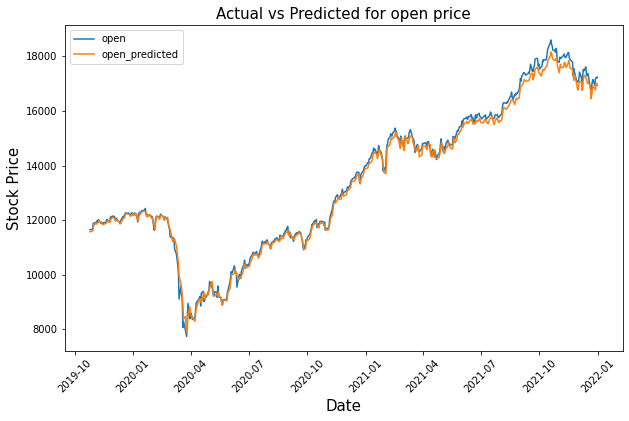

In [30]:
gs_slic_data[['open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

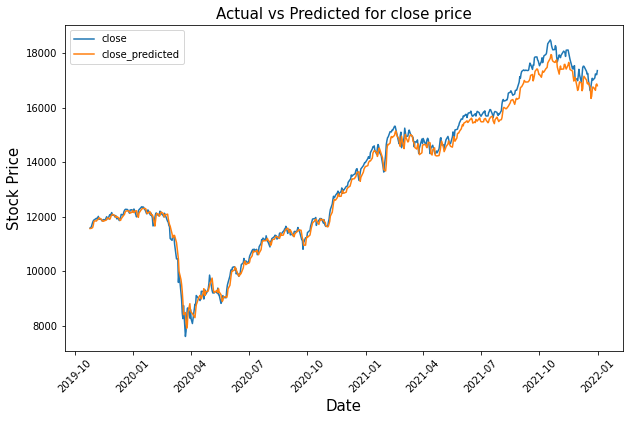

In [31]:
gs_slic_data[['close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

#LSTM2

In [50]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns
import pickle

In [33]:
with open('/content/drive/MyDrive/ir_project/binaries/stock_data_with_indicators', 'rb') as fileobj:
  df= pickle.load(fileobj)

In [51]:
df=nifty50

In [52]:
df=df[6:]

In [53]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),Sochastic oscillator index,William index,Relative Strength Index,Sentiment
6,6,2010-01-12,5251.10,5300.50,5200.95,5210.40,206748015,8648.49,30.121739,-69.878261,70.571887,-0.245283
7,7,2010-01-13,5212.60,5239.20,5169.55,5233.95,200774550,8430.48,45.576787,-54.423213,73.860898,-0.062500
8,8,2010-01-14,5234.50,5272.85,5232.50,5259.90,171282618,7824.43,63.941967,-36.058033,77.144741,-0.200000
9,9,2010-01-15,5259.90,5279.85,5242.45,5252.20,167242355,6927.87,62.142857,-37.857143,73.929528,0.103448
10,10,2010-01-18,5253.65,5292.50,5228.95,5274.85,153687597,6659.87,80.412371,-19.587629,77.191791,0.333333


In [51]:
df.dtypes

Unnamed: 0                             int64
Date                          datetime64[ns]
Open                                 float64
High                                 float64
Low                                  float64
Close                                float64
Shares Traded                          int64
Turnover (Rs. Cr)                    float64
Sochastic oscillator index           float64
William index                        float64
Relative Strength Index              float64
dtype: object

In [54]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
# d = pd.to_datetime(train_df.index)
# train_df['Month'] = d.strftime("%m")
# train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,Unnamed: 0,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),Sochastic oscillator index,William index,Relative Strength Index,Sentiment
0,6,2010-01-12,5251.10,5300.50,5200.95,5210.40,206748015,8648.49,30.121739,-69.878261,70.571887,-0.245283
1,7,2010-01-13,5212.60,5239.20,5169.55,5233.95,200774550,8430.48,45.576787,-54.423213,73.860898,-0.062500
2,8,2010-01-14,5234.50,5272.85,5232.50,5259.90,171282618,7824.43,63.941967,-36.058033,77.144741,-0.200000
3,9,2010-01-15,5259.90,5279.85,5242.45,5252.20,167242355,6927.87,62.142857,-37.857143,73.929528,0.103448
4,10,2010-01-18,5253.65,5292.50,5228.95,5274.85,153687597,6659.87,80.412371,-19.587629,77.191791,0.333333


In [55]:
# List of considered Features
FEATURES = [ 'Sochastic oscillator index','William index','Open', 'Close', 'Relative Strength Index','Sentiment'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Sochastic oscillator index', 'William index', 'Open', 'Close', 'Relative Strength Index', 'Sentiment']


,Sochastic oscillator index,William index,Open,Close,Relative Strength Index,Sentiment,Prediction
2967,76.136044,-23.863956,16937.75,17086.25,50.045939,0.0,17086.25
2968,97.976311,-2.023689,17177.60,17233.25,57.402618,0.0,17233.25
2969,87.895265,-12.104735,17220.10,17213.60,56.113855,0.0,17213.60
2970,82.420409,-17.579591,17201.45,17203.95,55.401212,0.0,17203.95
2971,91.763566,-8.236434,17244.50,17354.05,63.754483,0.0,17354.05


In [56]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2972, 6)


In [57]:
data.head(10)

,Unnamed: 0,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),Sochastic oscillator index,William index,Relative Strength Index,Sentiment
0,6,2010-01-12,5251.10,5300.50,5200.95,5210.40,206748015,8648.49,30.121739,-69.878261,70.571887,-0.245283
1,7,2010-01-13,5212.60,5239.20,5169.55,5233.95,200774550,8430.48,45.576787,-54.423213,73.860898,-0.062500
2,8,2010-01-14,5234.50,5272.85,5232.50,5259.90,171282618,7824.43,63.941967,-36.058033,77.144741,-0.200000
3,9,2010-01-15,5259.90,5279.85,5242.45,5252.20,167242355,6927.87,62.142857,-37.857143,73.929528,0.103448
4,10,2010-01-18,5253.65,5292.50,5228.95,5274.85,153687597,6659.87,80.412371,-19.587629,77.191791,0.333333
5,11,2010-01-19,5274.20,5287.80,5218.65,5225.65,141424524,6197.52,42.840779,-57.159221,58.606819,0.074074
6,12,2010-01-20,5226.10,5256.70,5201.40,5221.70,167867201,7170.51,39.824360,-60.175640,57.314313,-0.101449
7,13,2010-01-21,5220.20,5220.35,5085.45,5094.15,190009431,7943.76,4.201884,-95.798116,31.305017,-0.411765
8,14,2010-01-22,5094.15,5094.15,4954.85,5036.00,270251977,10414.08,24.033763,-75.966237,25.218139,-0.178571
9,15,2010-01-25,5034.55,5035.70,4983.05,5007.90,166405391,5714.17,15.711536,-84.288464,22.726854,-0.375000


In [58]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = 3
print(index_Close)
# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    print(data.shape)
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y
#print(data.iloc[sequence_length,5])
# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

3
(2378, 6)
(644, 6)
(2328, 50, 6) (2328,)
(594, 50, 6) (594,)
0.05295399003075463
0.05295399003075463


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(6))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

300 50 6


In [60]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/50
146/146 [==============================] - 53s 329ms/step - loss: 0.0102 - val_loss: 9.3385e-04
Epoch 2/50
146/146 [==============================] - 44s 299ms/step - loss: 9.3660e-05 - val_loss: 0.0011
Epoch 3/50
146/146 [==============================] - 45s 311ms/step - loss: 7.0389e-05 - val_loss: 7.5726e-04
Epoch 4/50
146/146 [==============================] - 44s 302ms/step - loss: 6.1687e-05 - val_loss: 7.9954e-04
Epoch 5/50
146/146 [==============================] - 44s 300ms/step - loss: 6.2916e-05 - val_loss: 5.6820e-04
Epoch 6/50
146/146 [==============================] - 44s 301ms/step - loss: 6.9054e-05 - val_loss: 7.3134e-04
Epoch 7/50
146/146 [==============================] - 44s 300ms/step - loss: 6.1309e-05 - val_loss: 4.6826e-04
Epoch 8/50
146/146 [==============================] - 44s 303ms/step - loss: 5.9037e-05 - val_loss: 9.8130e-04
Epoch 9/50
146/146 [==============================] - 44s 302ms/step - loss: 6.6963e-05 - val_loss: 4.3033e-04
Epoch 10/

In [61]:
model.save('/content/drive/MyDrive/ir_project/binaries/lstm_2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ir_project/binaries/lstm_2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ir_project/binaries/lstm_2/assets


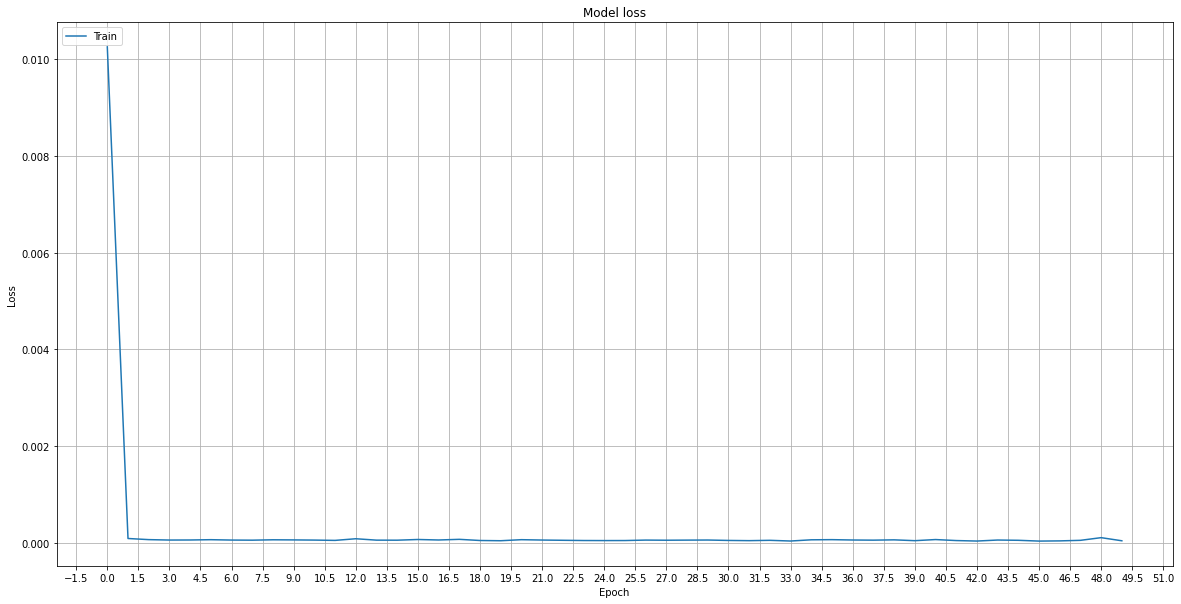

In [62]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [63]:
from keras.metrics import RootMeanSquaredError
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
rmse=RootMeanSquaredError()
rms=rmse(y_test_unscaled, y_pred)
print(np.round(rms, 2))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 365.73
416.82
Mean Absolute Percentage Error (MAPE): 2.69 %
Median Absolute Percentage Error (MDAPE): 2.71 %


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


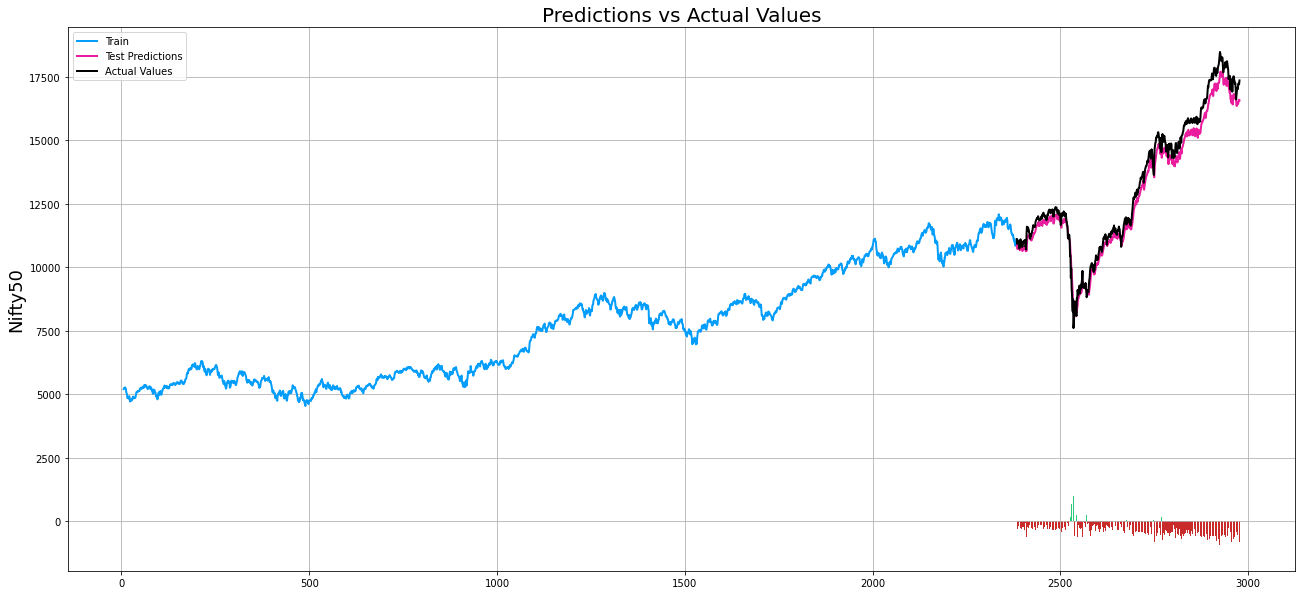

In [99]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=500)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe
#valid = valid[valid['Date'] > display_start_date]
#train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel('Nifty50', fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()


#Plotting

In [77]:
# Merging actual and predicted data for better visualization
gs_slic_data = pd.concat([df .iloc[-594:].copy(),pd.DataFrame(y_test_unscaled,columns=['close'],index=gstock_data .iloc[-594:].index)], axis=1)

In [78]:
gs_slic_data[['close']] = scaler_pred.inverse_transform(gs_slic_data[['Close']]) 

In [81]:
len(y_test_unscaled)

594

2978

#End

In [ ]:
len(y_test_unscaled)

In [ ]:
len(df)

In [ ]:
np_data_unscaled

In [ ]:
y=np.append(y_train,y_test_unscaled)

In [ ]:
import plotly.graph_objects as go

import pandas as pd

# Load data
df = pd.read_csv("/content/drive/MyDrive/ir_project/data/NIFTY_50.csv")
df1 = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv")
df['Date']=pd.to_datetime(df['Date'])
# Create figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(df.Date), y=list(df.Open),name='Actual Price'))
fig.add_trace(go.Scatter(x=list(df.Date), y=list(y),name='Predicted Price'))

# Set title
fig.update_layout(
    title_text="Nifty50 Predicted vs Actual Price"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
                dict(count=5,
                     label="5y",
                     step="year",
                     stepmode="backward")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)



fig.show()



In [14]:
with open('/content/drive/MyDrive/ir_project/binaries/news_with_sentiments', 'rb') as fileobj:
  news_with_sentiments= pickle.load(fileobj)

In [15]:
with open('/content/drive/MyDrive/ir_project/binaries/stock_data_with_indicators', 'rb') as fileobj:
  nifty50= pickle.load(fileobj)

In [16]:
nifty50.head()

,Unnamed: 0,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),Sochastic oscillator index,William index,Relative Strength Index
0,0,2010-01-04,5200.90,5238.45,5167.10,5232.20,148652424,6531.61,0.0,0.0,0.000000
1,1,2010-01-05,5277.15,5288.35,5242.40,5277.90,240844424,7969.62,0.0,0.0,100.000000
2,2,2010-01-06,5278.15,5310.85,5260.05,5281.80,216147837,7892.60,0.0,0.0,100.000000
3,3,2010-01-07,5281.80,5302.55,5244.75,5263.10,181246734,6890.99,0.0,0.0,92.725757
4,4,2010-01-08,5264.25,5276.75,5234.70,5244.75,201910800,7777.04,0.0,0.0,85.597397


In [18]:
news_with_sentiments

,_id,Date,Title,Article,Link,Sentiment,probability,predicted_sentiment
197,7ead28fb9f37e2bfd45f14be4fcc1a96,2010-01-04 00:35:00,Steel sales jump 50% in Dec on firm demand,NEW DELHI: India’s top steelmakers led by Stee...,https://economictimes.indiatimes.com/industry/...,Positive,0.843574,POSITIVE
198,4ade1816abd1a174e77c33613c2dbb22,2010-01-04 00:40:00,Petrobras to exit ONGC’s gas block,NEW DELHI: Brazil’s Petrobras had decided to q...,https://economictimes.indiatimes.com/industry/...,Positive,0.998001,NEGATIVE
199,5c6bb6fcfe3aa6a411881c960515b49c,2010-01-04 00:42:00,PE entry to help Himadri fund expansion,MUMBAI: Private equity Bain Capital has bought...,https://economictimes.indiatimes.com/markets/s...,Positive,0.981639,POSITIVE
200,ecc15c4a58383b385578927646a1ca74,2010-01-04 00:46:00,India Inc’s top bosses help themselves with Es...,NEW DELHI: The three months leading to Decembe...,https://economictimes.indiatimes.com/markets/s...,Positive,0.957147,POSITIVE
202,1aab1cae901738671d5b3d3b0b194c60,2010-01-04 00:48:00,Infosys results may not make an impact on open...,MUMBAI: It’s a tradition that has been followe...,https://economictimes.indiatimes.com/markets/s...,Positive,0.999382,NEGATIVE
...,...,...,...,...,...,...,...,...
6031671,54032ca2c9daaf1893d9572adf98e961,2020-12-31 11:08:00,Enphase joins Tesla as latest clean tech firm ...,By Brian Eckhouse Another clean tech firm is ...,https://economictimes.indiatimes.com/markets/s...,Positive,0.992695,POSITIVE
6031998,17a3fd896fb84ec28a1fb589eb20d973,2020-12-31 08:30:00,Gold on course for best year in a decade,"Dec 31: Gold edged higher on Thursday, headin...",https://economictimes.indiatimes.com/markets/c...,Positive,0.999885,POSITIVE
6161667,42a40a9d7cd7d305da392afb7a07d1f6,2020-12-31 12:44:00,India's protesting farmers hold key to self-re...,MUMBAI/NEW DELHI: Indian farmer Shingara Singh...,https://economictimes.indiatimes.com/news/econ...,Positive,0.816178,NEGATIVE
6164460,4d0f61723653ab5768484196a19a017e,2020-12-31 11:14:00,Tejas Networks bags order worth $13 mn for sup...,New Delhi: Communications equipment firm Tejas...,https://economictimes.indiatimes.com/industry/...,Positive,0.959207,POSITIVE


In [20]:
import datetime

In [46]:
nifty50['Sentiment']=0.0

In [ ]:
sentiment=''
for ind in nifty50.index:
  df_temp = news_with_sentiments[(nifty50['Date'][ind] >= news_with_sentiments['Date'])&(nifty50['Date'][ind] < news_with_sentiments['Date']+datetime.timedelta(days=1))]
  np=0
  nn=0
  #print(len(df_temp))
  if len(df_temp)!=0:
    for i in df_temp.index:
      if df_temp['predicted_sentiment'][i]=='POSITIVE':
        np+=1
      else:
        nn+=1
    print(np)
    nifty50['Sentiment'][ind]=(np-nn)/(np+nn)

In [48]:
nifty50

,Unnamed: 0,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),Sochastic oscillator index,William index,Relative Strength Index,Sentiment
0,0,2010-01-04,5200.90,5238.45,5167.10,5232.20,148652424,6531.61,0.000000,0.000000,0.000000,0.000000
1,1,2010-01-05,5277.15,5288.35,5242.40,5277.90,240844424,7969.62,0.000000,0.000000,100.000000,-0.120000
2,2,2010-01-06,5278.15,5310.85,5260.05,5281.80,216147837,7892.60,0.000000,0.000000,100.000000,-0.050000
3,3,2010-01-07,5281.80,5302.55,5244.75,5263.10,181246734,6890.99,0.000000,0.000000,92.725757,0.191489
4,4,2010-01-08,5264.25,5276.75,5234.70,5244.75,201910800,7777.04,0.000000,0.000000,85.597397,-0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...
2973,243,2021-12-27,16937.75,17112.05,16833.20,17086.25,144777457,12567.03,76.136044,-23.863956,50.045939,0.000000
2974,244,2021-12-28,17177.60,17250.25,17161.15,17233.25,176026100,14553.76,97.976311,-2.023689,57.402618,0.000000
2975,245,2021-12-29,17220.10,17285.95,17176.65,17213.60,161679423,14320.79,87.895265,-12.104735,56.113855,0.000000
2976,246,2021-12-30,17201.45,17264.05,17146.35,17203.95,320831676,21929.19,82.420409,-17.579591,55.401212,0.000000


In [49]:
with open('/content/drive/MyDrive/ir_project/binaries/nifty50_with_sentiment', 'wb') as fileobj:
    pickle.dump(nifty50, fileobj)

#Results

In [101]:
from tensorflow import keras

In [109]:
model = keras.models.load_model('/content/drive/MyDrive/ir_project/binaries/lstm_1')